### Dependencies

In [1]:
import sys, os

import numpy as np
import torch as T
from scipy.integrate import solve_ivp

from dataclasses import dataclass

import torch_optimizer as optim_all

import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8-whitegrid")

### Physical Model

In [2]:
def build_true_model(x, t, omega=1., zeta=0.05, F0=1., 
                     forcing_freq=1.2, friction_force_ratio=0.5):
    """
    A function that gets the displacement, velocity and time as an input, and returns the true vector field output (velocity and acceleration)

    Parameters
    ----------
    x : ndarray 

    t : ndarray
    
    omega : float
    
    zeta : float
    
    F0 : float

    forcing_freq : float

    friction_force_ratio : float

    Returns
    -------
    ndarray
        an array with the two vector field values, for the given input
    """
    return [
        x[1],
        - 2 * omega * zeta * x[1]
        - omega ** 2 * x[0]
        - friction_force_ratio * np.sign(x[1])
        + F0 * np.cos(forcing_freq * t)
    ]

### Coefficients dictionary

In [3]:
class CoeffsDictionary(T.nn.Module):
    """
    A class for initializing, storing, and updating the ksi coefficients
    These coefficients are the linear weights of a neural network
    The class inherits from the torch.nn.Module
    """
    def __init__(self, n_combinations):

        super(CoeffsDictionary, self).__init__()
        self.linear = T.nn.Linear(n_combinations, 1, bias=False)
        # Setting the weights to zeros
        self.linear.weight = T.nn.Parameter(0 * self.linear.weight.clone().detach())
    
    def forward(self, x):
        
        return self.linear(x)

### Features function

In [27]:
def apply_features(x, t, poly_order=2, phases=(), sgn_flag=False, torch_flag=True):
    """
    Applies the feature candidates to the given data

    Parameters
    ----------
    x : torch.Tensor

    t : torch.Tensor
    
    poly_order : int
    
    phases : iterable
    
    sgn_flag : bool
    
    torch_flag : bool

    Returns
    -------
    numpy.ndarray or torch.Tensor
    
    """
    if torch_flag:
        return T.column_stack(
            (
                *[T.cos(ph * t) for ph in phases], # trigonometric features
                *[T.sign(x[:, k]) for k in (0, 1)] * sgn_flag, # signum features
                *[T.ones(size=(x.shape[0],))] * (poly_order >= 0), 
                *[x[:, 0], x[:, 1]] * (poly_order >= 1),
                *[x[:, 0] ** 2, x[:, 0] * x[:, 1], x[:, 1] ** 2] * (poly_order >= 2),
                *[x[:, 0] ** 3, x[:, 0] ** 2 * x[:, 1], x[:, 0] * x[:, 1] ** 2, x[:, 1] ** 3,] * (poly_order >= 3),
                *[x[:, 0] ** 4, x[:, 0] ** 3 * x[:, 1], x[:, 0] ** 2 * x[:, 1] ** 2, x[:, 0] * x[:, 1] ** 3, x[:, 1] ** 4] * (poly_order >= 4), # polynomial features
            )
        )
    else:
        return np.column_stack(
        (
            *[np.cos(ph * t) for ph in phases], # trigonometric features                
            *[np.sign(x[:, k]) for k in (0, 1)] * sgn_flag, # signum features 
            *[np.ones(shape=(x.shape[0],))] * (poly_order >= 0), 
            *[x[:, 0], x[:, 1]] * (poly_order >= 1),
            *[x[:, 0] ** 2, x[:, 0] * x[:, 1], x[:, 1] ** 2] * (poly_order >= 2),
            *[x[:, 0] ** 3, x[:, 0] ** 2 * x[:, 1], x[:, 0] * x[:, 1] ** 2, x[:, 1] ** 3,] * (poly_order >= 3),
            *[x[:, 0] ** 4, x[:, 0] ** 3 * x[:, 1], x[:, 0] ** 2 * x[:, 1] ** 2, x[:, 0] * x[:, 1] ** 3, x[:, 1] ** 4] * (poly_order >= 4), # polynomial features
        )
    )


### 4th order Runge-Kutta constraint function

In [34]:
def apply_rk4_SparseId(x, coeffs, times, timesteps, params):
    """
    A function that applies the fourth order Runge-Kutta scheme to the given data in order to derive the ones in the following timestep
    During this process the approximate derivatives are used

    Parameters
    ----------
    x : torch.Tensor
    coeffs : CoeffsDictionary object
    times : torch.Tensor
    timesteps : torch.Tensor
    params : parameters dataclass

    Returns
    -------
    torch.Tensor
    Predictions of both displacement and velocity for the next timesteps
    
    """
    d1 = apply_features(x, times, poly_order=params.poly_order, phases=params.phases, sgn_flag=params.sgn_flag)
    k1 = T.column_stack((x[:, 1].unsqueeze(1), (- 2 * params.zeta * params.omega * x[:, 1] - params.omega ** 2 * x[:, 0]).unsqueeze(1) + T.cos(params.forcing_freq * times) + coeffs(d1)))
    
    xtemp = x + 0.5 * timesteps * k1
    d2 = apply_features(xtemp, times + 0.5 * timesteps, poly_order=params.poly_order, phases=params.phases, sgn_flag=params.sgn_flag)
    k2 = T.column_stack((xtemp[:, 1].unsqueeze(1), (- 2 * params.zeta * params.omega * xtemp[:, 1] - params.omega ** 2 * xtemp[:, 0]).unsqueeze(1) + T.cos(params.forcing_freq * (times + 0.5 * timesteps)) + coeffs(d2)))

    xtemp = x + 0.5 * timesteps * k2
    d3 = apply_features(xtemp, times + 0.5 * timesteps, poly_order=params.poly_order, phases=params.phases, sgn_flag=params.sgn_flag)
    k3 = T.column_stack((xtemp[:, 1].unsqueeze(1), (- 2 * params.zeta * params.omega * xtemp[:, 1] - params.omega ** 2 * xtemp[:, 0]).unsqueeze(1) + T.cos(params.forcing_freq * (times + 0.5 * timesteps)) + coeffs(d3)))

    xtemp = x + timesteps * k3
    d4 = apply_features(xtemp, times + timesteps, poly_order=params.poly_order, phases=params.phases, sgn_flag=params.sgn_flag)
    k4 = T.column_stack((xtemp[:, 1].unsqueeze(1), (- 2 * params.zeta * params.omega * xtemp[:, 1] - params.omega ** 2 * xtemp[:, 0]).unsqueeze(1) + T.cos(params.forcing_freq * (times + 0.5 * timesteps)) + coeffs(d4)))

    return x + (1 / 6) * (k1 + 2 * k2 + 2 * k3 + k4) * timesteps

### Learning function

In [35]:
def learn_sparse_model(coeffs, train_set, times, params, lr_reduction=10):
    """"
    A function that calculates which ksi coefficients lead to optimal prediction
    The updating of the coefficients is performed in a deep learning fashion

    Parameters
    ----------
    coeffs : CoeffsDictionary object

    train_set : torch.Tensor

    times : torch.Tensor

    params : parameters dataclass

    phases : tuple

    lr_reduction : int

    Returns
    -------
    coeffs

    loss_track
    """
    # Define optimizer
    opt_func = optim_all.RAdam(
        coeffs.parameters(), lr=params.lr, weight_decay=params.weightdecay
    )
    # Define loss function
    criteria = T.nn.MSELoss()
    # pre-allocate memory for loss_fuction
    loss_track = np.zeros((params.num_iter, params.num_epochs))

    # Training 

    for p in range(params.num_iter):
        for g in range(params.num_epochs):
            coeffs.train()

            opt_func.zero_grad()

            loss_new = T.autograd.Variable(T.tensor([0.0], requires_grad=True))
            weights = 2 ** (-0.5 * T.linspace(0, 0, 1))

            timesteps_i = T.tensor(np.diff(times, axis=0)).float()
            y_total = train_set

            # One forward step predictions

            y_pred = apply_rk4_SparseId(y_total[:-1], coeffs, times[:-1], timesteps=timesteps_i, params=params)

            # One backward step predictions
            y_pred_back = apply_rk4_SparseId(y_total[1:], coeffs, times[1:], timesteps=-timesteps_i, params=params)

            loss_new += criteria(y_pred, y_total[1:]) + weights[0] * criteria(
                y_pred_back, y_total[:-1]
            )

            # loss_new /= y[0].shape[0]
            loss_track[p, g] += loss_new.item()
            loss_new.backward()
            opt_func.step()

            sys.stdout.write("\r [Iter %d/%d] [Epoch %d/%d] [Training loss: %.2e] [Learning rate: %.2e]" % (p + 1, params.num_iter, g + 1, params.num_epochs, loss_track[p, g], opt_func.param_groups[0]["lr"],))

        # Removing the coefficients smaller than tol and set gradients w.r.t. them to zero
        # so that they will not be updated in the iterations
        Ws = coeffs.linear.weight.detach().clone()
        Mask_Ws = (Ws.abs() > params.tol_coeffs).type(T.float)
        coeffs.linear.weight = T.nn.Parameter(Ws * Mask_Ws)

        coeffs.linear.weight.register_hook(lambda grad: grad.mul_(Mask_Ws))
        new_lr = opt_func.param_groups[0]["lr"] / lr_reduction
        opt_func = optim_all.RAdam(coeffs.parameters(), lr=new_lr, weight_decay=params.weightdecay)

    return coeffs, loss_track

#### Random seed

In [102]:
randSeed = 42

T.manual_seed(randSeed)
np.random.seed(seed=randSeed)

### Parameters dataclass

In [150]:
@dataclass
class parameters:
    # bs: int = 1
    num_epochs: int = 1000
    num_iter = 3
    lr: float = 1e-2
    weightdecay: float = 0.0
    timefinal: float = 50.0
    timestep: float = 5e-3
    # normalize: bool = False
    tol_coeffs: float = 5e-2

    omega: float = 1.0
    zeta: float = 0.05

    forcing_freq: float = 1.2
    F0: float = 1.
    friction_force_ratio: float = 0.5

    noisy_measure_flag: bool = True
    noise_level: float = 1e-1
    noisy_input_flag: bool = True
    omega_noise: float = 5e-2
    zeta_noise: float = 2e-1

    poly_order: int = 3
    phases: np.ndarray = np.arange(1., 2.01, 0.1)
    sgn_flag: bool = False
    
Params = parameters()

if Params.noisy_input_flag:
    Params.omega = np.random.normal(loc=Params.omega, scale=Params.omega_noise)
    Params.zeta = np.random.normal(loc=Params.zeta, scale=Params.zeta_noise)

### Generate (noisy) measurements - Training Data

In [151]:
ts = np.arange(0, Params.timefinal, Params.timestep)

# Initial condition and simulation time
x0 = [0.1, 0.1]

# Solve the equation
sol = solve_ivp(
    lambda t, x: build_true_model(x, t, omega=Params.omega, zeta=Params.zeta, 
                                  friction_force_ratio=Params.friction_force_ratio, 
                                  forcing_freq=Params.forcing_freq), 
    t_span=[ts[0], ts[-1]], y0=x0, t_eval=ts
    )

x_denoised = np.transpose(sol.y)

# Generate noisy measurements
if Params.noisy_measure_flag:
    x = np.random.normal(loc=x_denoised, scale=Params.noise_level * np.abs(x_denoised), size=x_denoised.shape)
else:
    x = x_denoised

### Learn the $\xi$ coefficients

In [152]:
train_dset = T.tensor(x).float()
times = T.tensor(ts).unsqueeze(1).float()

no_of_terms = apply_features(train_dset[:2], times[:2], 
                             poly_order=Params.poly_order, 
                             phases=Params.phases,
                             sgn_flag=Params.sgn_flag).shape[1]

coeffs = CoeffsDictionary(no_of_terms)

# Learning Coefficients
coeffs, loss_track = learn_sparse_model(coeffs, train_dset, times, Params)
learnt_coeffs = coeffs.linear.weight.detach().clone().t().numpy()

learnt_coeffs

 [Iter 3/3] [Epoch 1000/1000] [Training loss: 3.52e-03] [Learning rate: 1.00e-04]

array([[ 0.        ],
       [ 0.        ],
       [-0.7673104 ],
       [ 0.        ],
       [-0.        ],
       [-0.        ],
       [-0.        ],
       [-0.        ],
       [-0.        ],
       [-0.        ],
       [-0.        ],
       [-0.        ],
       [-0.21051835],
       [ 0.11274413],
       [ 0.06822762],
       [ 0.07780129],
       [ 0.        ],
       [ 1.3768295 ],
       [-2.047379  ],
       [-3.1748164 ],
       [ 1.2643173 ]], dtype=float32)

### Generate data to be plotted (for refined time intervals) 

In [153]:
learnt_deri = lambda t, z: (np.array([z[1], 
                                      - 2 * Params.zeta * Params.omega * z[1] 
                                      - Params.omega ** 2 * z[0] 
                                      + apply_features(
                                            np.expand_dims(z, axis=0), 
                                            t, 
                                            poly_order=Params.poly_order,
                                            phases=Params.phases, 
                                            sgn_flag=Params.sgn_flag,
                                            torch_flag=False) @ learnt_coeffs 
                                      + np.cos(Params.forcing_freq * t)], dtype=object))

sol_learnt = solve_ivp(learnt_deri, [ts[0], ts[-1]], x0, t_eval=ts,)
x_learnt = np.transpose(sol_learnt.y)

### Plotting

#### Directories setup

In [154]:
dir_plot_path = "\\\\tudelft.net\\staff-homes\\L\\cllathourakis\\Desktop\\ResearchAssistant\\research\\code\\current\\friction ID results"
new_dir = "30"

if os.path.isdir(os.path.join(dir_plot_path, new_dir)):
    print("""
    ------------------------------------------------------------------------------
    WARNING, the directory already exists, you are about to overwrite some data!!!
    ------------------------------------------------------------------------------
    """, sep=os.linesep)
else:
    os.makedirs(os.path.join(dir_plot_path, new_dir))

#### Plot and save Displacement figure

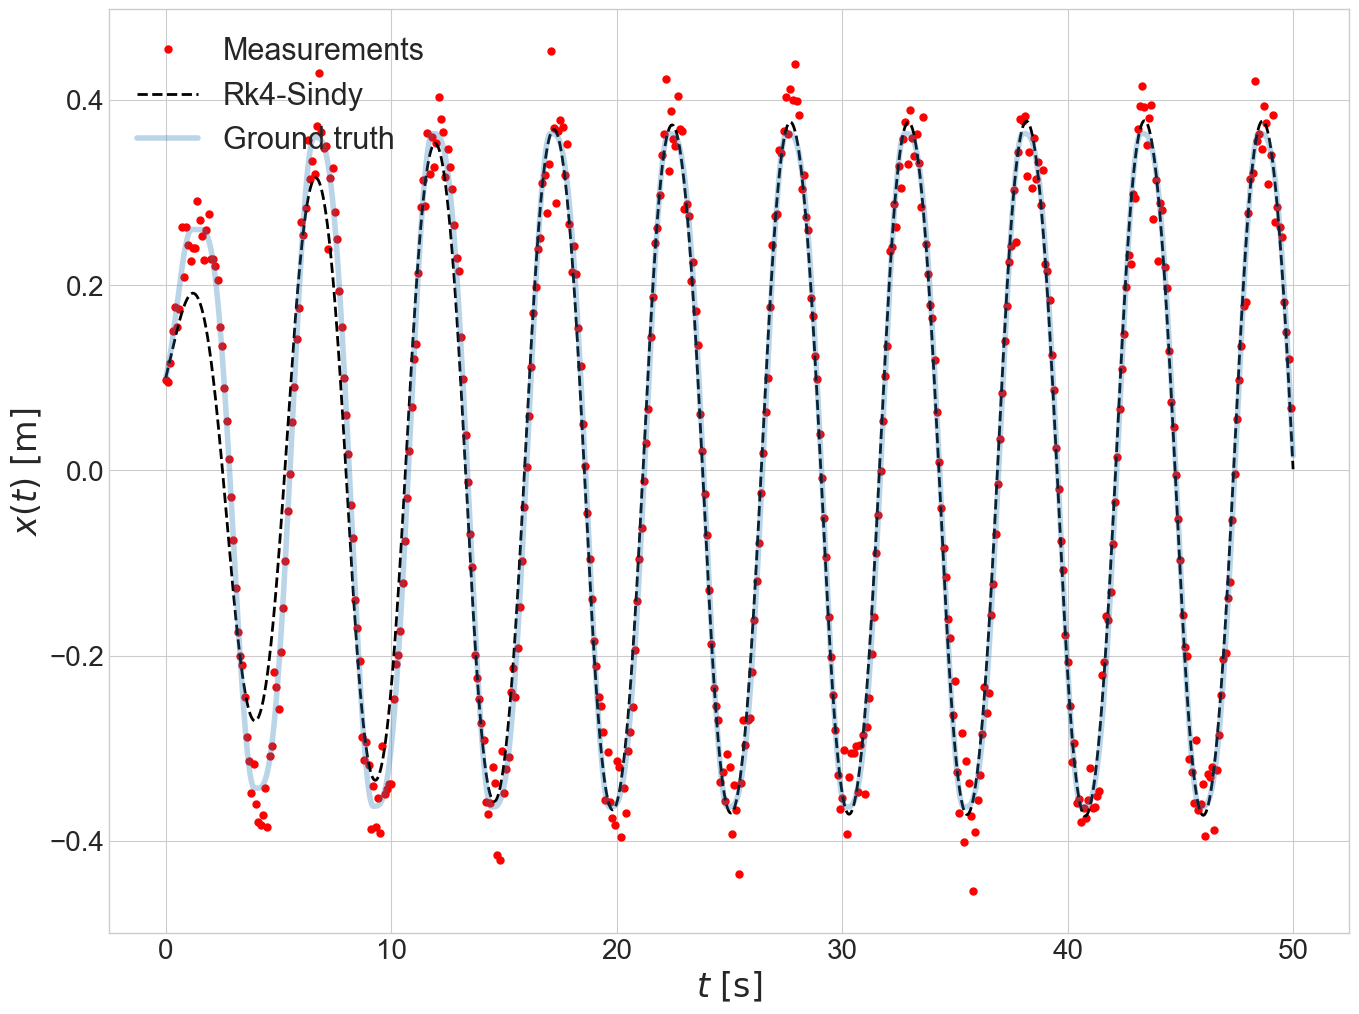

In [155]:
plt.figure(figsize=(16,12))

plt.plot(ts[::20], x[::20, 0], "ro", markersize=5, label="Measurements")
plt.plot(ts, x_learnt[:, 0], "k--", linewidth=2, label="Rk4-Sindy")
plt.plot(ts, x_denoised[:, 0], alpha=0.3, linewidth=4, label="Ground truth")

plt.legend(fontsize=22)#, bbox_to_anchor=(1., 0.6))#, loc='upper right')
plt.xlabel(r"$t \, \, \mathrm{[s]}$", fontsize=24)
plt.ylabel(r"$x(t) \, \, \mathrm{[m]}$", fontsize=24)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.savefig(os.path.join(dir_plot_path, new_dir, "d.png"), bbox_inches='tight')

plt.show()

#### Plot and save Velocity figure

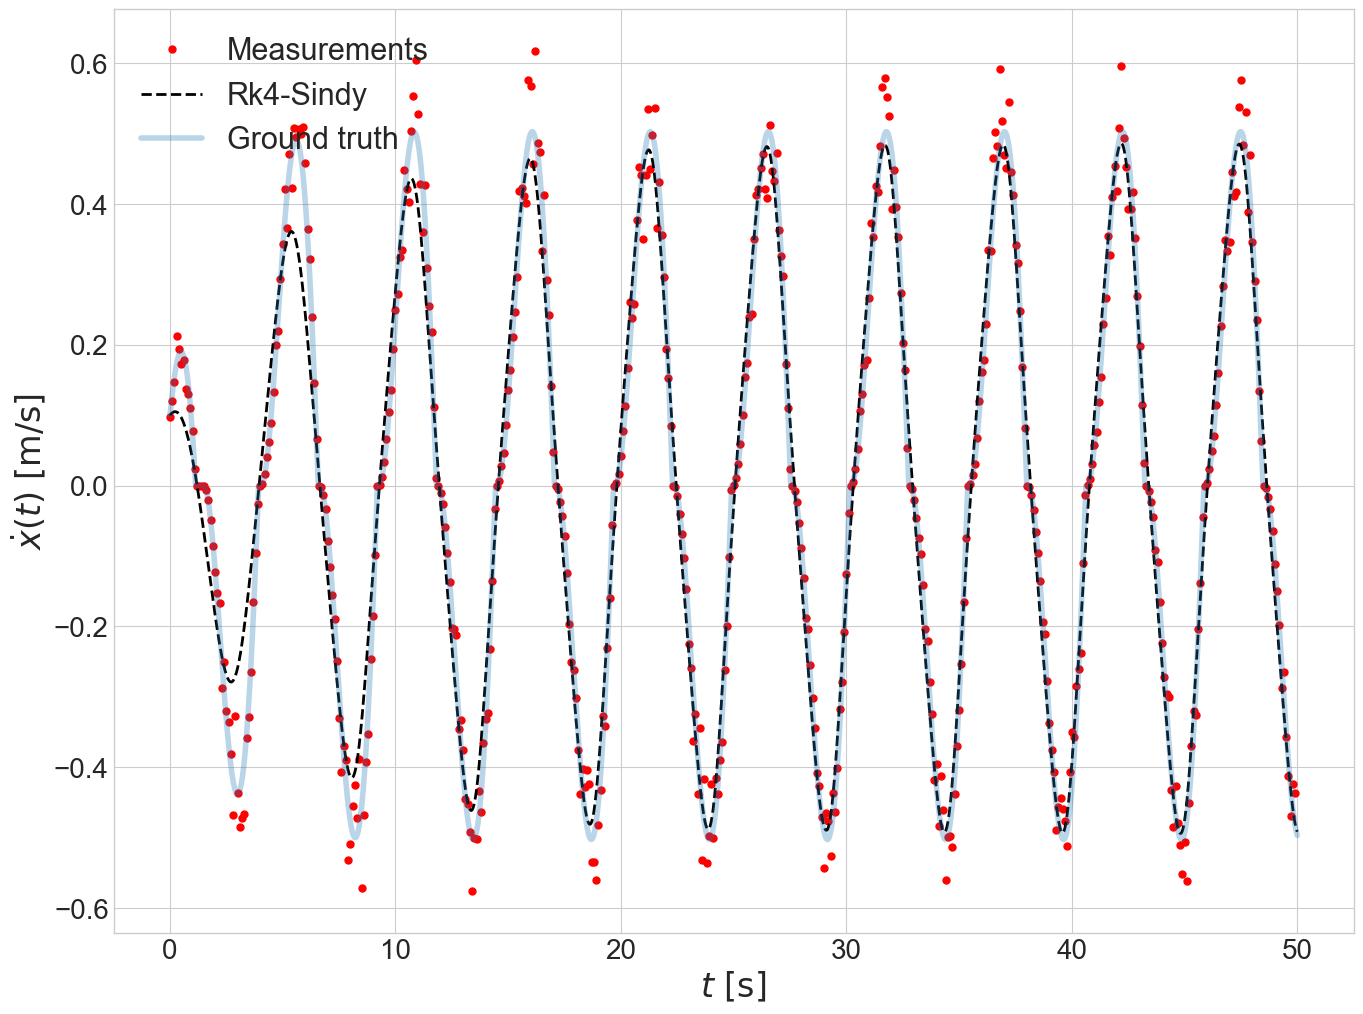

In [156]:
plt.figure(figsize=(16,12))

plt.plot(ts[::20], x[::20, 1], "ro", markersize=5, label="Measurements")
plt.plot(ts, x_learnt[:, 1], "k--", linewidth=2, label="Rk4-Sindy")
plt.plot(ts, x_denoised[:, 1], alpha=0.3, linewidth=4, label="Ground truth")

plt.legend(fontsize=22)#, bbox_to_anchor=(1.1, 1.05))
plt.xlabel(r"$t \, \, \mathrm{[s]}$", fontsize=24)
plt.ylabel(r"$\dot{x}(t) \, \, \mathrm{[m/s]}$", fontsize=24)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.savefig(os.path.join(dir_plot_path, new_dir, "v.png"), bbox_inches='tight')

plt.show()

#### Plot and save Error figure

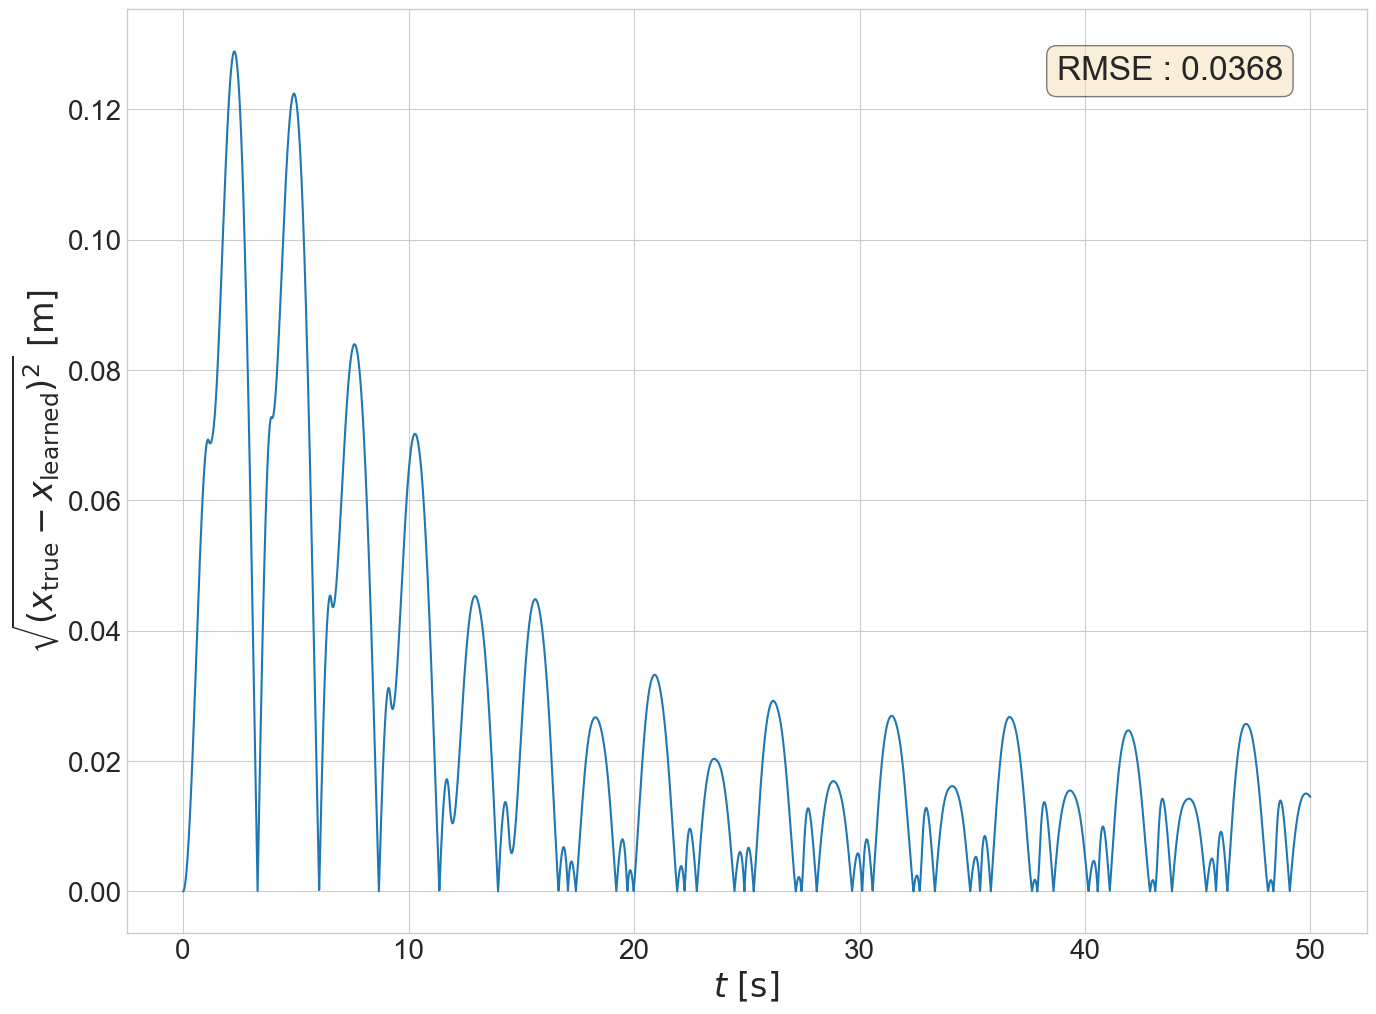

In [157]:
ind = 0

squaredError = np.sqrt((x_denoised[:, ind] - x_learnt[:, ind]) ** 2)

fig, ax = plt.subplots(figsize=(16,12))

ax.plot(ts, squaredError, label="Squared Error")

rmse = np.sqrt(((x_denoised[:, ind] - x_learnt[:, ind]) ** 2).sum() / x_learnt.shape[0])
textstr = f"RMSE : {rmse:.4f}"

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

# place a text box in upper left in axes coords
ax.text(0.75, 0.95, textstr, transform=ax.transAxes, fontsize=24,
        verticalalignment='top', bbox=props)



ax.set_xlabel(r"$t \, \, \mathrm{[s]}$", fontsize=24)
# plt.ylabel(r"$\sqrt{(\dot{x}_{\mathrm{true}} - \dot{x}_{\mathrm{learned}}) ^2} \, \, \mathrm{[m/s]}$", fontsize=24)
ax.set_ylabel(r"$\sqrt{(x_{\mathrm{true}} - x_{\mathrm{learned}}) ^2} \, \, \mathrm{[m]}$", fontsize=24)

ax.tick_params(axis='both', which='major', labelsize=20)

plt.savefig(os.path.join(dir_plot_path, new_dir, "err.png"), bbox_inches='tight')

plt.show()
